### O que são Algoritmos Genéticos?

Os algoritmos genéticos (AG) são uma classe de algoritmos de otimização inspirados no processo de evolução natural. Eles são usados para resolver problemas complexos onde a busca por soluções pode ser muito difícil. Esses algoritmos pertencem à família das chamadas "metaheurísticas", que são estratégias gerais para encontrar soluções aproximadas.

### Princípios Básicos

Os algoritmos genéticos baseiam-se em três conceitos principais da biologia:

1. **Seleção Natural**: Os indivíduos (soluções) mais aptos têm mais chances de sobreviver e se reproduzir.
2. **Mutação**: Pequenas alterações são introduzidas aleatoriamente nas soluções, promovendo diversidade genética.
3. **Cruzamento (ou Crossover)**: Duas soluções são combinadas para criar uma nova solução, aproveitando as características de ambas.

### Funcionamento de um Algoritmo Genético

1. **Inicialização**: O algoritmo começa com uma população inicial de soluções, que pode ser gerada aleatoriamente ou com base em heurísticas.

2. **Avaliação**: Cada solução é avaliada usando uma função de fitness, que mede quão boa essa solução é em relação ao problema.

3. **Seleção**: As soluções são selecionadas para reprodução com base em sua aptidão. Métodos comuns incluem torneio, roleta e seleção por ranking.

4. **Cruzamento**: As soluções selecionadas são combinadas para formar novos indivíduos. Isso pode ser feito de várias maneiras, como cruzamento de um ponto ou múltiplos pontos.

5. **Mutação**: Pequenas alterações são aplicadas às novas soluções para manter a diversidade genética e evitar a convergência prematura.

6. **Substituição**: A nova população é formada, substituindo parte ou toda a população antiga.

7. **Repetição**: O processo é repetido por várias gerações até que uma condição de parada seja atingida (como um número fixo de gerações ou uma solução satisfatória).

### Aplicações dos Algoritmos Genéticos

Os algoritmos genéticos são aplicáveis em diversas áreas, incluindo:

- **Otimização**: Resolver problemas de otimização em engenharia, logística e design.
- **Aprendizado de Máquina**: Seleção de características e ajuste de hiperparâmetros.
- **Jogos e Simulações**: Desenvolvimento de estratégias de jogo e comportamento de personagens.
- **Bioinformática**: Análise de sequências genéticas e predição de estruturas de proteínas.

### Vantagens e Desvantagens

**Vantagens**:
- Capacidade de explorar grandes espaços de busca.
- Flexibilidade em relação ao tipo de problemas que podem ser abordados.
- Não requer conhecimento detalhado sobre a função de fitness.

**Desvantagens**:
- Pode ser computacionalmente intensivo.
- Não garante a solução ótima global.
- Sensível à escolha dos parâmetros (como taxa de mutação e tamanho da população).

### Conclusão

Os algoritmos genéticos são ferramentas poderosas para resolver problemas complexos de otimização e têm aplicações em diversas áreas. Compreender seu funcionamento e suas características permite utilizá-los de forma eficaz e adaptá-los às necessidades específicas de cada problema. Se você estiver interessado em implementá-los, muitos pacotes e bibliotecas estão disponíveis em várias linguagens de programação, facilitando o processo.

In [32]:
data = {

  'model'     :  None
, 'population':  None
, 'truthtable':  None
, 'fitness'   :  None
, 'mutation'  :  None

}

params = {
     'N'         : 64 # numero de indivíduos
,    'Z'         : 20 # numero de gerações
,    'p_fertil'  : 0.5 # individuos ferteis da geracao
,    'p_mut'     : 0.1 # prob mutação
,    'p_fitness' : 0.3 #prob fitness
,    'shape'     : (28,28) # tamanho da figura
,    'index'     : 21 # id modelo
}

In [1]:
#Preparação

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

from numpy.linalg import norm

import tensorflow as tf
mnist = tf.keras.datasets.mnist


In [3]:
def setPopulation():
    data['population'] = np.full((params['n_genes'], params['N'], params['Z']+1), np.inf)
    data['truthtable'] = np.full((params['n_genes'], params['N'], params['Z']+1), np.inf)
    data['fitness']    = np.full((params['n_genes'], params['N'], params['Z']), np.inf)
    data['mutation']   = np.full((params['n_genes'], params['N'], params['Z']), np.inf)


In [4]:
def setModel():
    (x_train, y_train),(x_test, y_test) = mnist.load_data()

    data['model'] = np.array(x_train[params['index']], dtype='float').flatten()
    data['model'][data['model']>0] = 1 # normalizacao (somente preto e branco)

    params['n_genes'] = data['model'].shape[0]


In [5]:
def showImage(input):
    plt.imshow(input.reshape(params['shape']), cmap='gray')
    plt.show()

In [6]:
def showImage2(gen):

    msg = "Geração: {} - Indivíduo: {} - Best Fitness: {}"

    ix = np.where(np.isin(data['fitness'][0,:,gen], max(data['fitness'][0,:,gen])))[0]
    print (msg.format(gen,ix[0],data['fitness'][0,ix[0],gen]))

    x1 = np.arange(params['N'])
    y1 = data['fitness'][0,:,gen]

    plt.plot(x1, y1, 'o-')
    plt.title('Fitness da geração:' + str(gen))
    plt.ylabel('%')
    plt.show()

    plt.imshow(data['population'][:,ix[0],gen].reshape(params['shape']), cmap='gray')
    plt.xlabel('Individuo')
    plt.show()

In [7]:
def initGeneration(gen):
    data['population'][:,:,gen] = np.random.choice([0,1],data['population'][:,:,gen].shape)

In [8]:
def calcFitness(ind,gen):
    data['truthtable'][:,ind,gen] = data['model'] == data['population'][:,ind,gen]
    data['fitness'][0,ind,gen] = np.sum(data['truthtable'][:,ind,gen],axis=0)/params['n_genes']


In [9]:
def selFerteis(gen):
    array = -np.array(data['fitness'][0,:,gen])
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    data['fitness'][1,:,gen] = ranks < params['p_fertil']*params['N']


In [10]:
def crossover(gen):

    ferteis = np.where(np.isin(data['fitness'][1,:,gen],[True]))

    temp = []
    temp2 = []
    temp3 = []

    for idf in ferteis[0]:
        temp.append(data['population'][:,idf ,gen]);
        temp2.append(np.where(np.isin(data['truthtable'][:,idf, gen],[False] ))[0]);

    for idx in range(0,len(temp),2):
        f1 = temp[idx]
        f2 = temp[idx+1]
        bdg_f1 = temp2[idx]
        bdg_f2 = temp2[idx+1]

        point = np.random.randint (params['n_genes'])
        #point = int(params['n_genes']/2)

        f3 = np.concatenate((f1[:point], f2[point:]))
        f4 = np.concatenate((f2[:point], f1[point:]))

        new_f1 = f1
        for i in bdg_f1:
            new_f1[i] = np.random.choice([0,1])
            #new_f1[i] = f2[i]

        new_f2 = f2
        for i in bdg_f2:
            #new_f2[i] = np.random.choice([0,1])
            new_f2[i] = f1[i]

        temp3.append(new_f1)
        temp3.append(new_f2)
        temp3.append(f3)
        temp3.append(f4)

    for idx in range(0,len(temp3)):
        novoIndividuo(temp3[idx], idx, gen+1)


In [11]:
def novoIndividuo(individuo, n, z):
    #print(individuo)
    data['population'][:, n, z] = mutation(individuo,n,z)


In [12]:
def mutation(individuo,n,z):
    if np.random.choice([0, 1], p=[1-params['p_mut'],params['p_mut']]):
        gM = np.random.randint(params['n_genes'])
        data['mutation'][gM,n,z] = True
        individuo[gM] = 1 - individuo[gM]

    return individuo


In [13]:
def evolution():

    for i in range(0, params['Z']-1):
        for j in range(0, params['N']):
            calcFitness(j,i)
        selFerteis(i)
        crossover(i)

        if i % 1 == 0:
            showImage2(i)

In [29]:

print(params)



{'N': 64, 'Z': 10, 'p_fertil': 0.5, 'p_mut': 0.1, 'p_fitness': 0.3, 'shape': (28, 28), 'index': 12, 'n_genes': 784}


In [30]:
setModel();


{'N': 64, 'Z': 10, 'p_fertil': 0.5, 'p_mut': 0.1, 'p_fitness': 0.3, 'shape': (28, 28), 'index': 12, 'n_genes': 784}


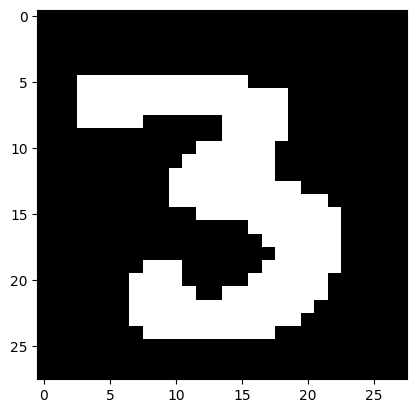

In [31]:
print(params)
showImage(data['model'])


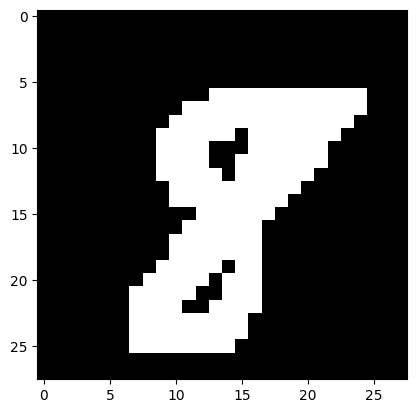

In [34]:

params = {
     'N'         : 64 # numero de indivíduos
,    'Z'         : 20 # numero de gerações
,    'p_fertil'  : 0.5 # individuos ferteis da geracao
,    'p_mut'     : 0.1 # prob mutação
,    'p_fitness' : 0.3 #prob fitness
,    'shape'     : (28,28) # tamanho da figura
,    'index'     :  55 # id modelo
}

setModel();
showImage(data['model'])


Geração: 0 - Indivíduo: 21 - Best Fitness: 0.5306122448979592


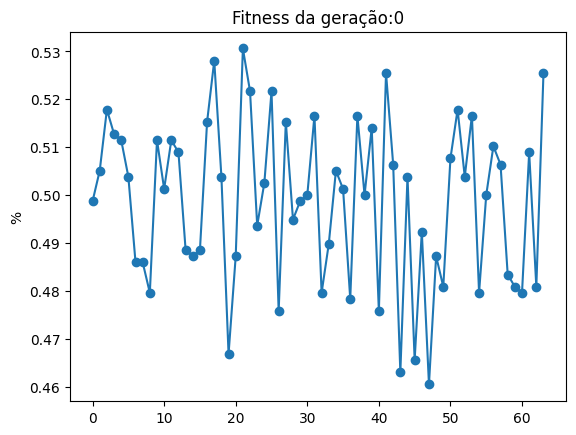

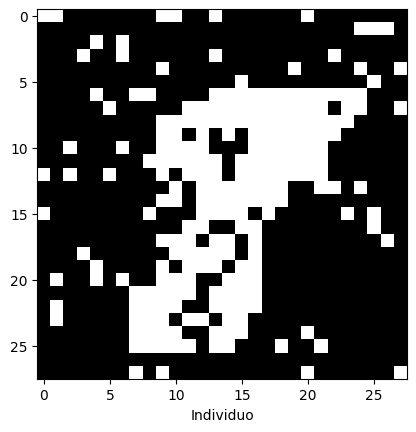

Geração: 1 - Indivíduo: 21 - Best Fitness: 0.8954081632653061


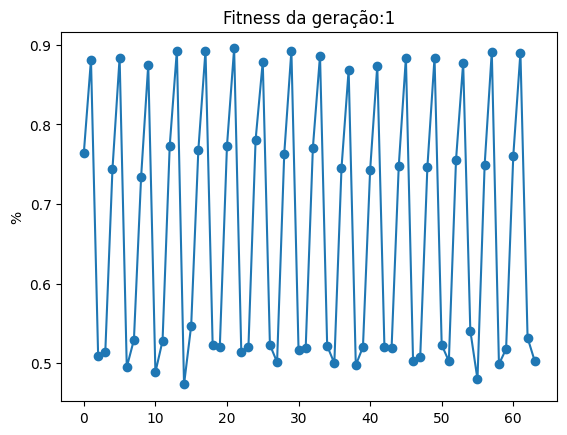

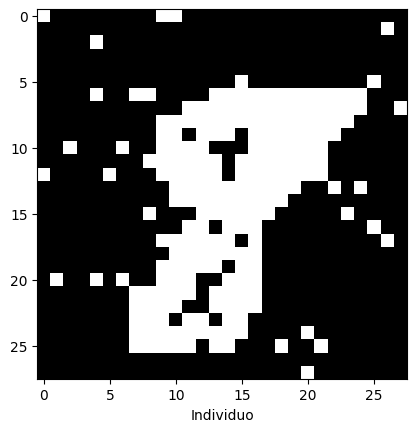

Geração: 2 - Indivíduo: 17 - Best Fitness: 0.9528061224489796


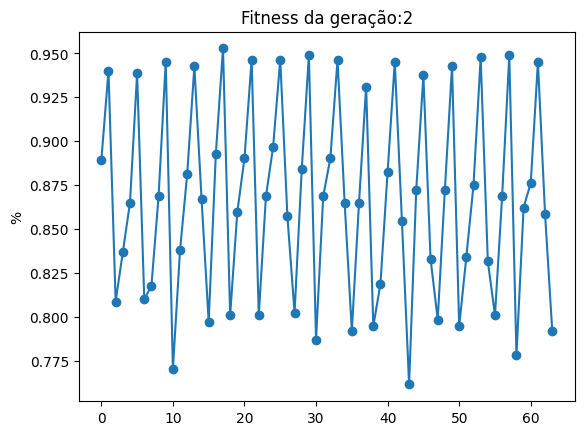

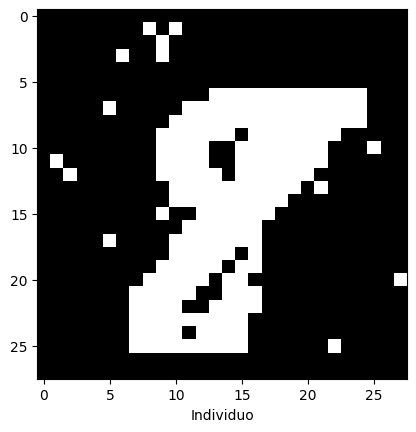

Geração: 3 - Indivíduo: 17 - Best Fitness: 0.9987244897959183


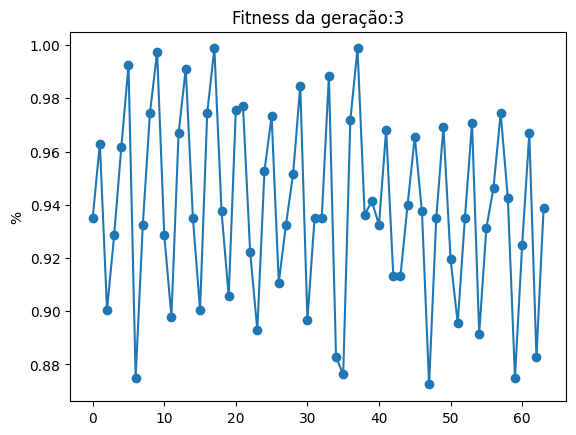

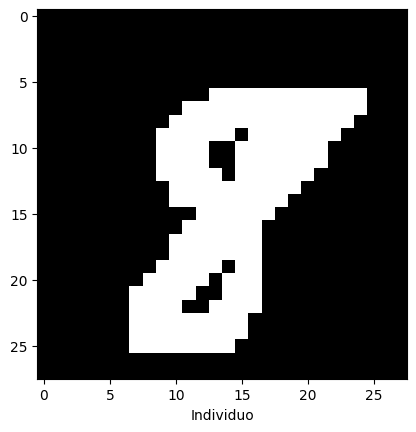

Geração: 4 - Indivíduo: 5 - Best Fitness: 1.0


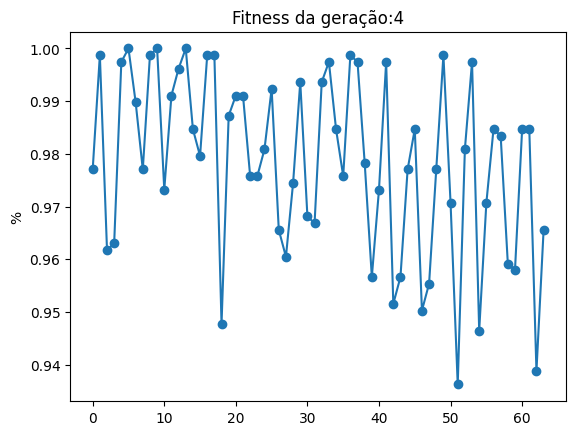

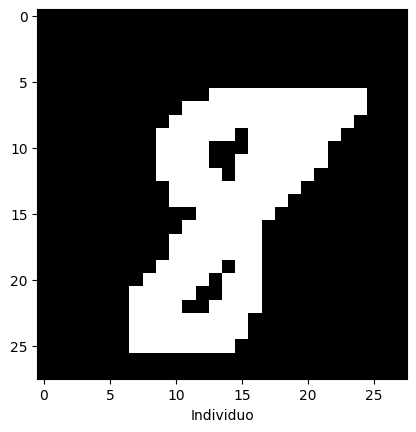

Geração: 5 - Indivíduo: 1 - Best Fitness: 1.0


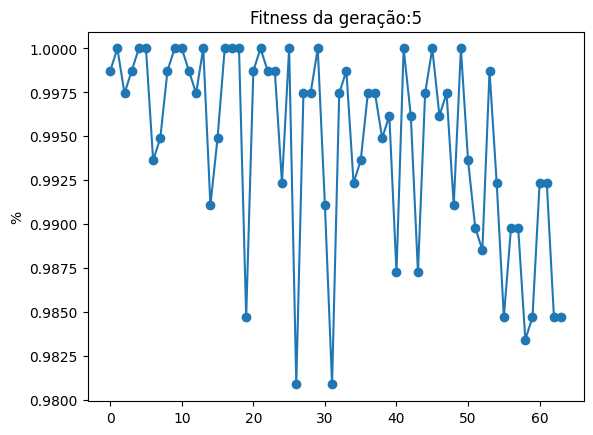

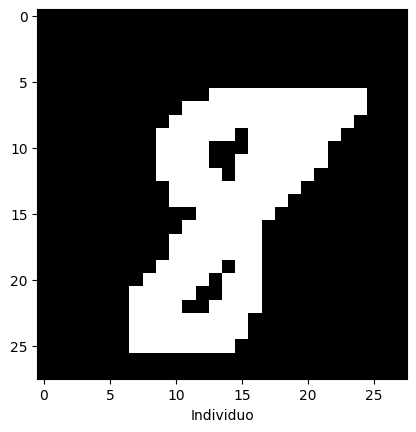

Geração: 6 - Indivíduo: 0 - Best Fitness: 1.0


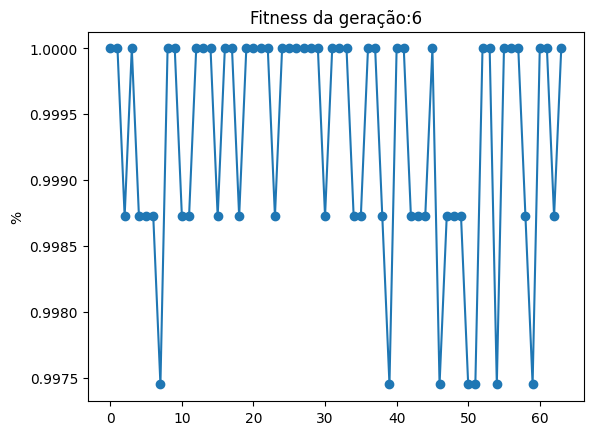

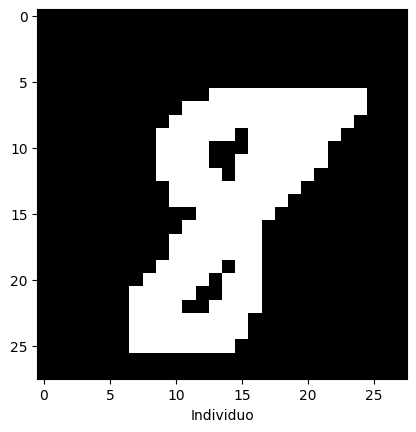

Geração: 7 - Indivíduo: 0 - Best Fitness: 1.0


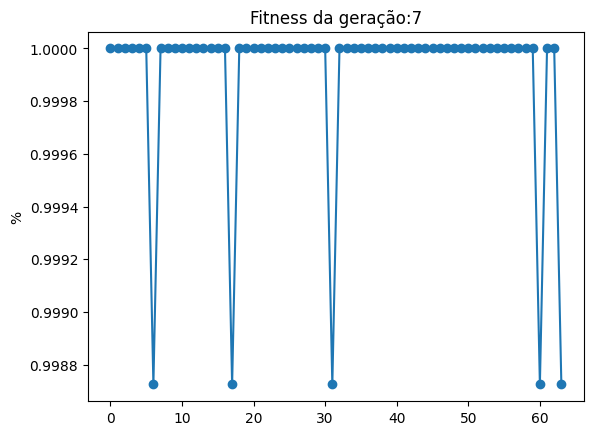

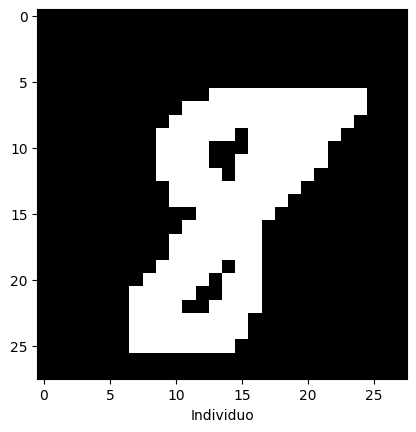

Geração: 8 - Indivíduo: 0 - Best Fitness: 1.0


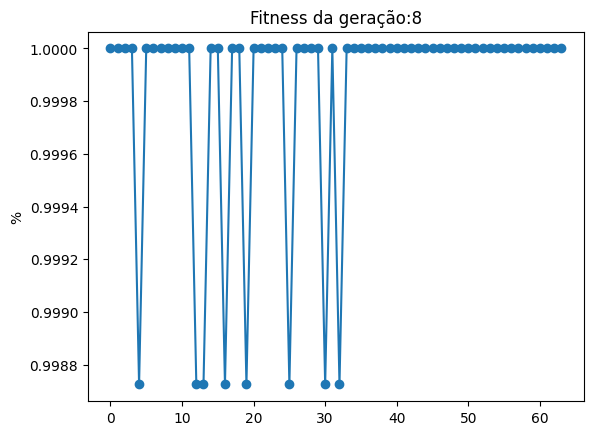

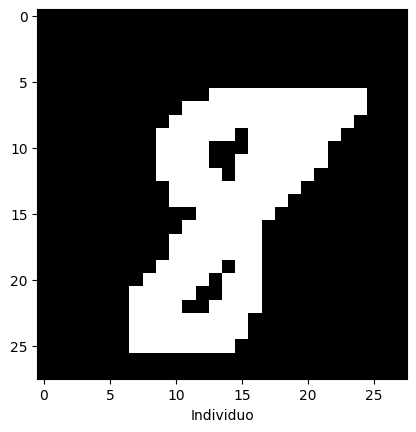

Geração: 9 - Indivíduo: 0 - Best Fitness: 1.0


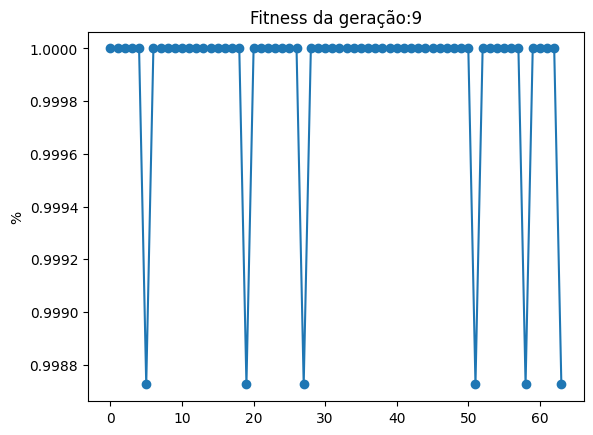

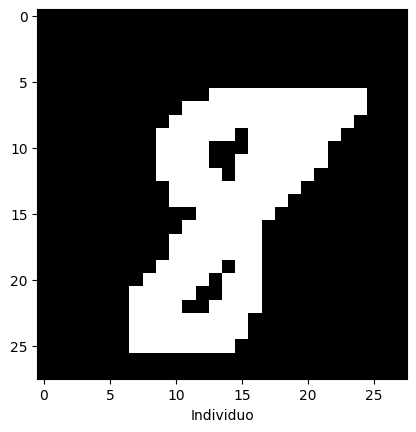

Geração: 10 - Indivíduo: 0 - Best Fitness: 1.0


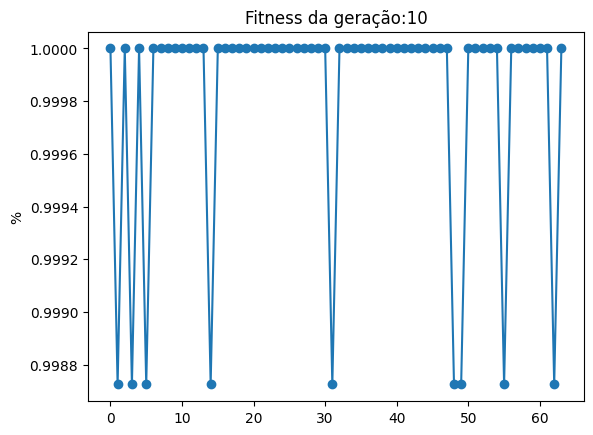

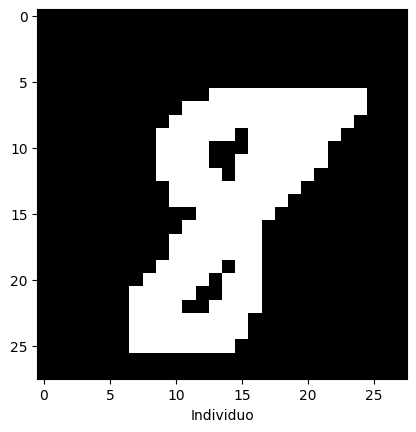

Geração: 11 - Indivíduo: 0 - Best Fitness: 1.0


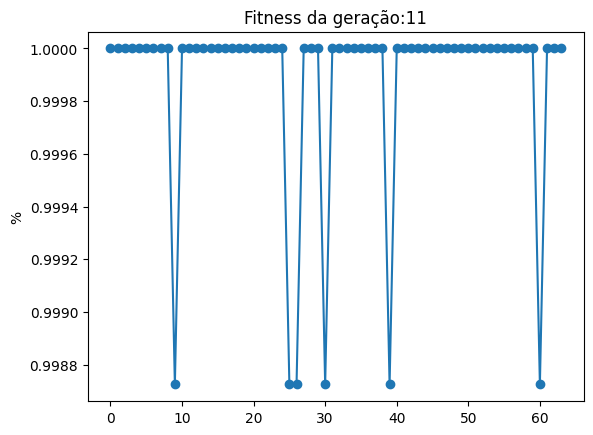

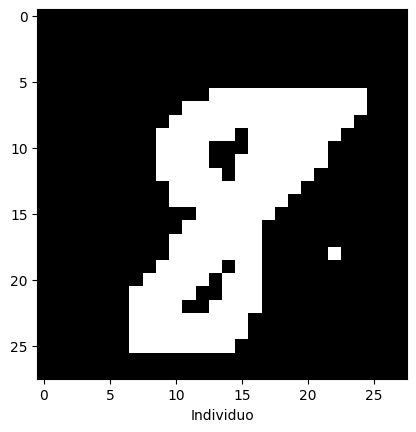

Geração: 12 - Indivíduo: 1 - Best Fitness: 1.0


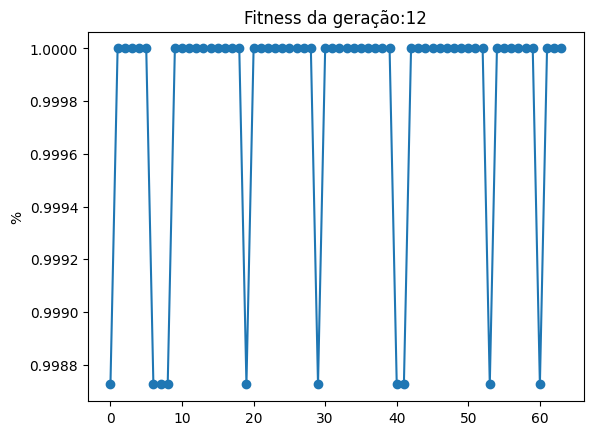

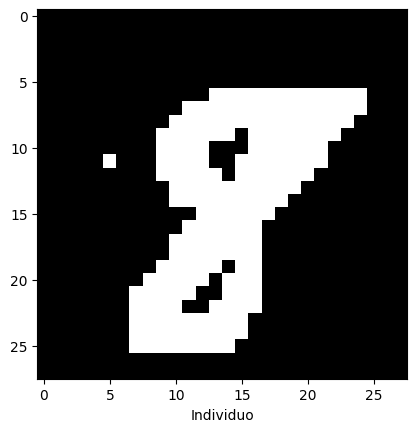

Geração: 13 - Indivíduo: 1 - Best Fitness: 1.0


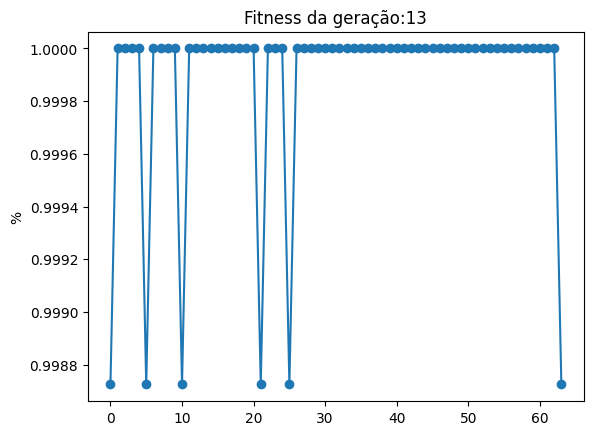

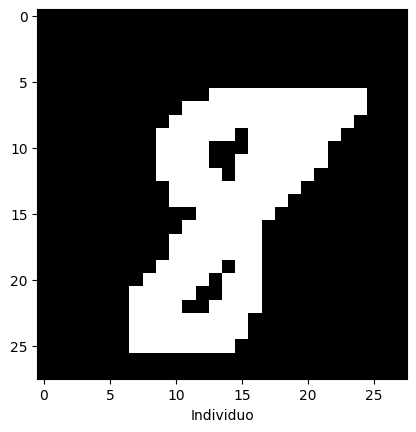

Geração: 14 - Indivíduo: 0 - Best Fitness: 1.0


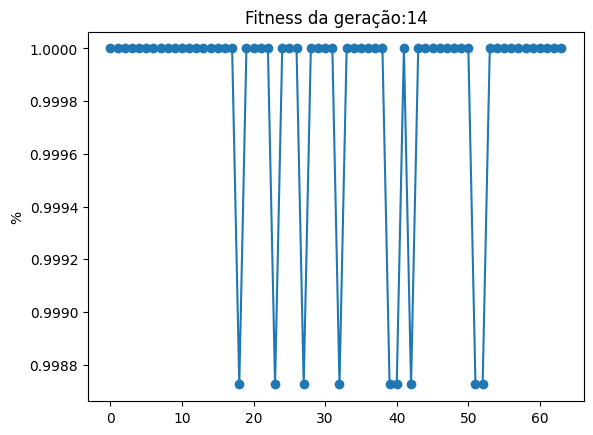

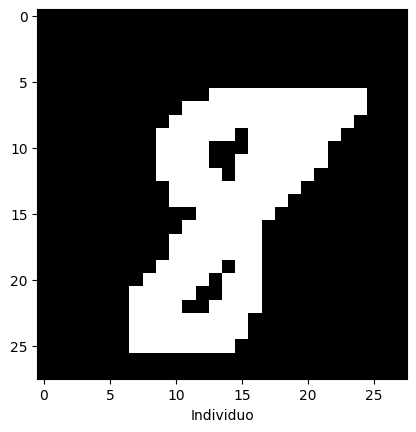

Geração: 15 - Indivíduo: 0 - Best Fitness: 1.0


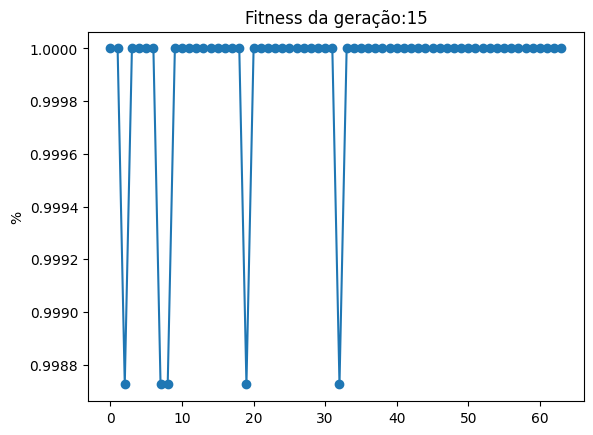

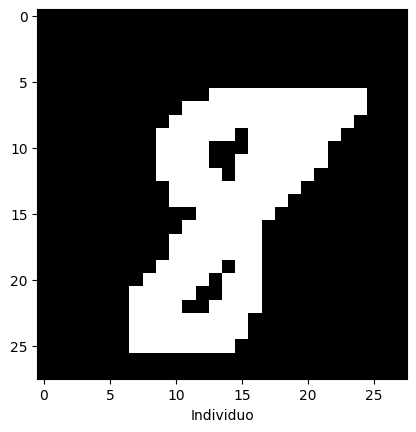

Geração: 16 - Indivíduo: 0 - Best Fitness: 1.0


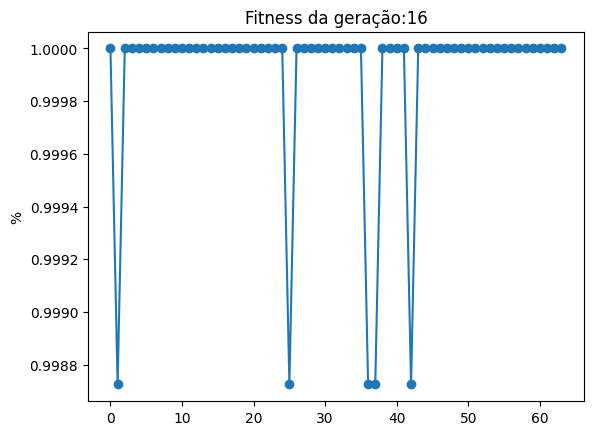

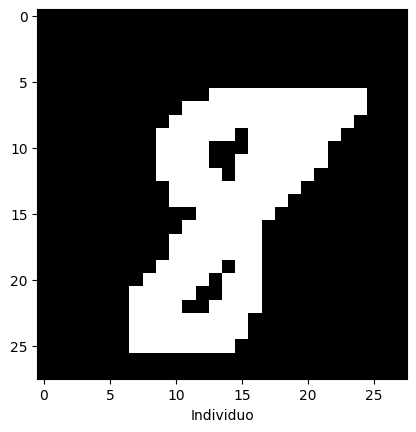

Geração: 17 - Indivíduo: 0 - Best Fitness: 1.0


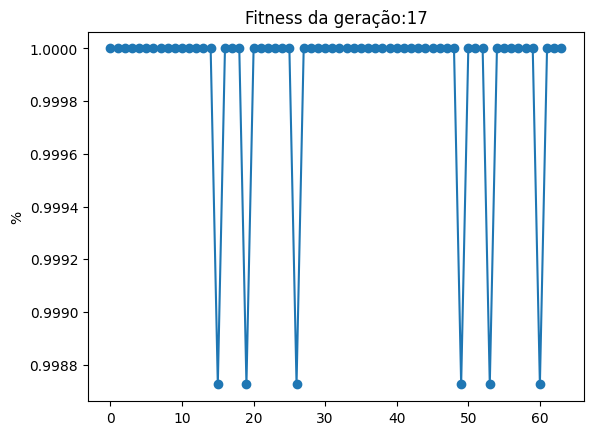

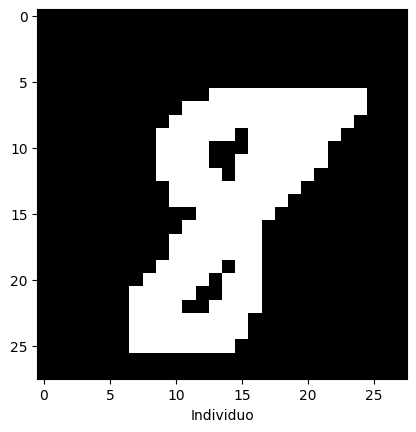

Geração: 18 - Indivíduo: 0 - Best Fitness: 1.0


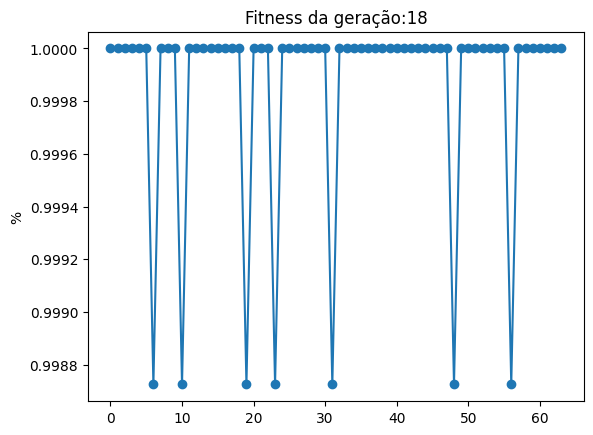

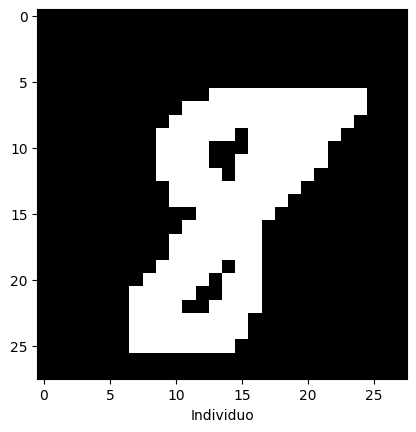

In [35]:

setModel();
setPopulation();
initGeneration(0);
evolution()